# Experiment 2: Big Data thoughput using dynamic pool of resource

This is part of the bebida project.

## Overview

### Goal

The obective is to show the Big Data resource dynamicity cost using several metrics. In other words, we want to see what is the waisted time due to node decomissioning in different conditions.

### Expectation

We expect that:
- for a small fragmentation (value to be define) and an utilisation < 0.8 the overhead should be under 10%.
- with a fragmentation next to 1 the overhead shoud be under < 10% if the utilisation is under 50%.
- expect that above a certain treshold of fragmentation and utilisation the thing goes wild!

### Experiment variables
- fixed number of resources (bigger is better)
- fixed HPC workload size in time (bigger is better)
- different level of dynamicity or fragmentation
  - from 0 to 1 (0.1 steps)
- different level of utilisation
  - from 10% to 90% (10% steps)
- Simple synthetic Big Data workload with (overloaded to get a max bound)

### Experiments results
- HPC RJMS scheduling
  - Makespan
  - Mean waiting time
  - Bounded slowdown
- Big data RJMS scheduling
  - Number of killed Big data:
    - job
    - executors
    - tasks

### Experiment setup

A grid'5000 cluster that run OAR as HPC RJMS and Hadoop YARN as Big Data RJMS. A prologue/epilogue system allows to decommisionned a node from YARN pool when a HPC job starts and recommissioned it whe the HPC job finish.

Replay a real HPC workload extracted from a real trace with a given utilisation and fragmentation


## Experiment protocole

1. [x] Define workload and associated platform
2. [x] Extract worload with diferent level of utilisation
3. [x] Define fragmentation, utilisation and waisted time metrics
4. [DEFERED: This will be done in the fragmentation project] Compute fragmentation of these extracted workload using Batsim and Bataar
5. [DEFERED: This will be done in the fragmentation project] Select experiments inputs with different fragmentation and utilisation level inside these workloads
6. [-] Generate simple HPC workload for experiment
6. [ ] Generate a Big Data overloaded syntetic workload
7. [x] Generate images to deploy on the nodes with all the experiments
8. [-] Write a script that run the experiment on Grid'5000
9. [ ] Run the actual experiment, gather and validate results
10. [ ] Compute figures to put on the paper :)


## Tools

This experiment heavily use the [evalys](https://github.com/oar-team/evalys) tool that provide analytics function to  anayse and plot inputs and outputs.

It also use the Grid'5000 testbed with a [fork of execo](https://github.com/mickours/execo) to run the experiments.

Images for Grid'5000 and Docker are made using [Kameleon](http://kameleon.imag.fr/) and the recipes provided in ``environments`` folder at the root of this repository 

## 1. Define workload and associated platform

Which trace to replay and which cluster will host experimentation

### *Which trace?*

#### HPC2N-2002-2.2-cln.swf seems to be a good candidate for small experiments.

**Description**:
Seth is a 120-node Linux cluster.

Each node contains two 240 AMD Athlon MP2000+ processors, running at 1.667 GHz. The total system peak performance is 800 Gflops. Nodes have 1 GB of RAM each, shared by the two processors. They are connected by a 3D SCI interconnect organized as a 4x5x6 grid, and by a fast Ethernet.

Scheduling is performed with the Maui scheduler.

**Caracteristics**:

- 240 procs
- util mean 0.601


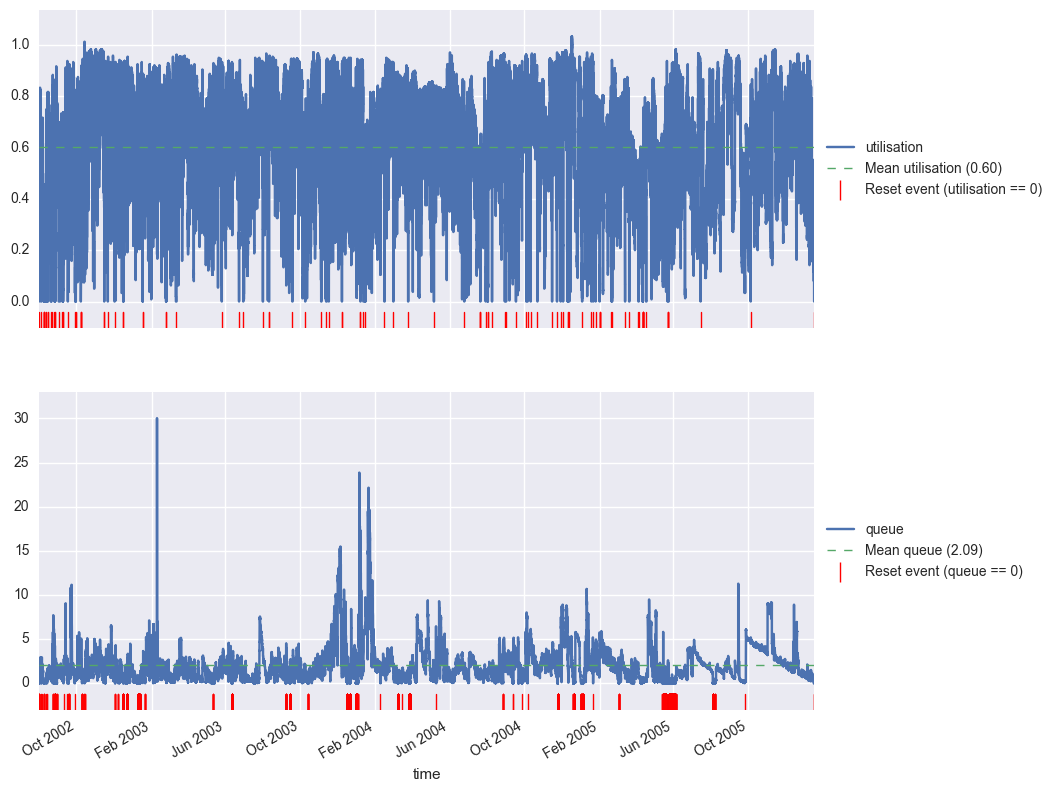

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

from evalys import workload
from evalys.metrics import load_mean
import seaborn

w_hpc2n = workload.Workload.from_csv("./HPC2N-2002-2.2-cln.swf")

w_hpc2n.plot(normalize=True)

#### METACENTRUM-2009-2.swf is a good cadidate for bigger experiments but it is much more heterogenous...

**Caracteristics**:
- 816 procs
- util mean 0.319

TODO: add more details

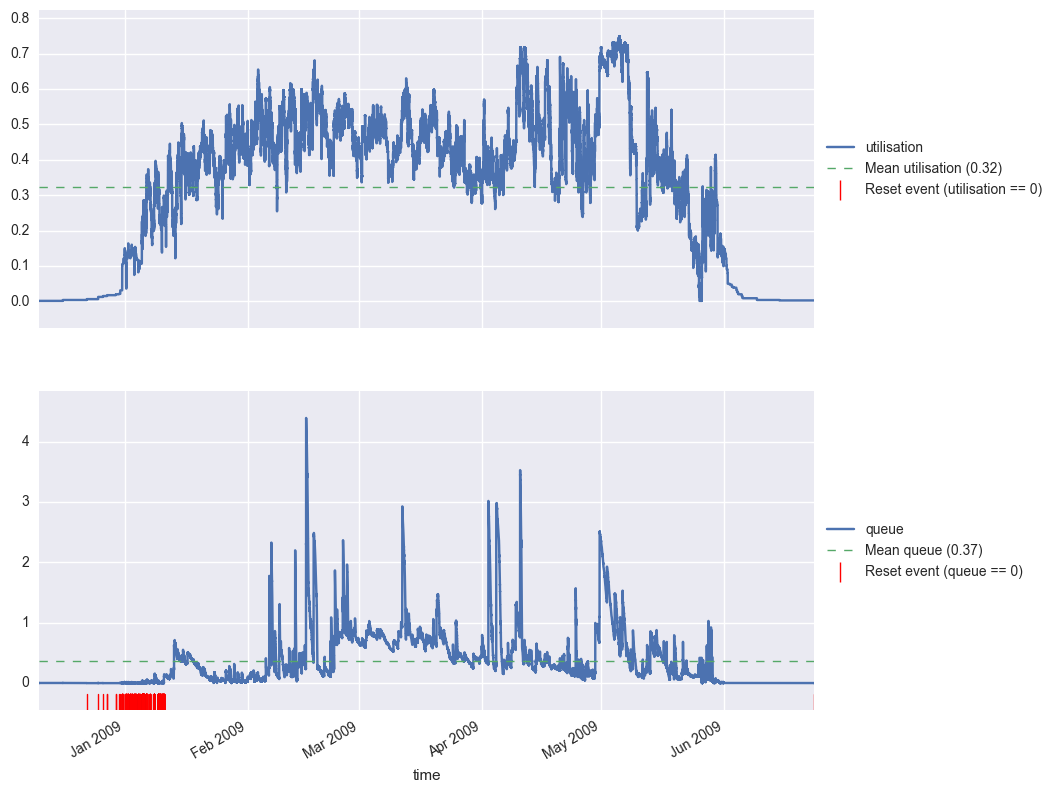

In [3]:
w_meta09 = workload.Workload.from_csv("./METACENTRUM-2009-2.swf")

w_meta09.plot(normalize=True)

### *Which cluster?*

On the Grid'5000 Nancy site Grisou is modern enough and
- Grisou = 816 procs OK for METACENTRUM
- Grisou 15 node = 240 procs OK for HPC2N

Desciption:
  grisou    (2016): 51 nodes (2 CPUs Intel Xeon E5-2630 v3, 8 cores/CPU, 126GB RAM, 2x558GB HDD, 10Gbps ethernet)

## 2. Extract workload with different level of utilisation

Real workload trace from Parallel workload archive:
http://www.cs.huji.ac.il/labs/parallel/workload/l_hpc2n/HPC2N-2002-2.2-cln.swf.gz

More info on the trace can be found here:
http://www.cs.huji.ac.il/labs/parallel/workload/l_hpc2n/index.html

The actual experiment imput is extracted parts of this workload that fits a certain level of utilisation and fragmentation.

Here is how to generate the input in the ``inputs`` directory: 

In [1]:
from evalys import workload
import pandas as pd
import os


def extract_periods(w, swf_trace):

    results_dir = "./inputs"
    variation = 0.1
    columns = ["file", "begin", "end", "norm_util", "variation",
               "period_in_hours", "iteration"]
    metadata_map = pd.DataFrame(columns=columns)

    os.makedirs(results_dir, exist_ok=True)
    for period in [60, 168]:

        for util in range(1, 10):
            res_table = w.extract_periods_with_given_utilisation(
                period, util / 10, variation=variation, nb_max=20)

            for i, results in enumerate(res_table):
                filename = "extracted_{}_{}H_{}util+-{}_{}".format(
                    swf_trace,
                    period, util * 10,
                    variation,
                    i)
                print("Export: {} \n{}".format(filename, results))
                filepath = results_dir + "/" + filename + ".swf"
                results.to_csv(filepath)
                # Add metadata
                metadata_map = metadata_map.append(
                    [{"file": filename,
                      "begin": results.ExtractBegin,
                      "end": results.ExtractEnd,
                      "norm_util": util / 10,
                      "variation": variation,
                      "period_in_hours": period,
                      "nb_max_resources": w.MaxProcs,
                      "iteration": i}])
    metadata_map.to_csv(results_dir + "/extract_metadata.csv", index=False)


if __name__ == "__main__":
    swf_trace = "HPC2N-2002-2.2-cln"
    w = workload.Workload.from_csv("./" + swf_trace + ".swf")
    extract_periods(w, swf_trace)

/usr/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_0 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_1 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_2 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_3 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_4 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_5 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_6 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_7 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_8 
Export: extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_9 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_0 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_1 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_2 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_3 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_4 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_5 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_6 
Export: extracted_HPC2N-2002-2.2-cln_60H_20util+

## 3. Metrics definition

### Utilisation
where $J$ is the number of jobs 
$$Util=\frac{\sum_{j=0}^J executionTime_j * allocatedResources_j}{totalTime * totalResources}$$

### Fragmentation
Definition of the 1 dimensional fragmentation is  define by Gher and Shneider CCGRID09.
Where $N$ the total number of resources and $f_i$ the size in time of the free interval $i$ for the resource $r$

$$Frag_r=\frac{\sum\limits_{i=1}^{N} {f_{i,r}^p}}{\left(\sum\limits_{i=1}^{N}{f_{i,r}}\right)^p}$$

Because we do not take into account contiguity issue with Big Data jobs we do not use the 2D fragmentation that is really expensive to compute: we chose to take the mean the fragmentation on all resources to have an overall fragmentation.

After some tests, We chose to fix $p=2$ as it is proposed in the paper.

### Big Data Throughput (Waisted time)

We need a baseline to know the overhead of our system. The base line
is a BDA worload running on static nodes corespounding to the
utilisation: If there is 40% of 100 resources free do the baseline
compute on 40 nodes.

The *waisted time* metric is the difference between the baseline and the
bebida makespan.

We need to generate a BDA workload but what is the utilisation of this
workload inside its slot? Maybe we need a metric that give an amount
of computation and not a time.

Compute the thoughput with a computation time in finished tasks can be
a good metrics

Big data job throughput can be defined by:

$$\sum{sucessfulTasks_i * taskDuration_i}$$

in a given time $T$

Nb failed executor is also important this is a direct value (can be normalyse by the number of executors)



## 4. Compute fragmentation of these extracted workload using Batsim and Bataar

I use the ``oarteam/batsim:bebida`` Docker container to run Batsim simulation and get the fragmentation of each utilisation.

It use a script to run experiments using batsim that is provided in the batsim/tools folder. The YAML to define the experiment is [here](bebida_expe_2_config.yaml).

Run the experiment with this command:
```bash
cd experiments/big_data_throughput
docker run -ti -v $PWD:/expe oarteam/batsim:bebida \
    /root/batsim/tools/experiments/execute_instances.py /expe/bebida_expe_2_config.yaml
```

Then compute the fragmetation:


In [4]:
from evalys.jobset import JobSet


def compare_jobsets_fragmentation(extract_metadata):

    frag_serie = pd.Series()
    frag_dict = {}
    for index, row in extract_metadata.iterrows():
        file = "./run/results/" + index + "_jobs.csv"
        try:
            js = JobSet.from_csv(file, resource_bounds=(0, 239))
            frag = js.fragmentation(begin_time=row.begin, end_time=row.end)

            mean_frag = frag.mean()
            # Store data
            frag_dict[index] = frag
            frag_serie.set_value(index, round(mean_frag, 2))
        except FileNotFoundError as e:
            print("Warning: Error on file {}:\n{}".format(index, e))
        
    return frag_serie, frag_dict

    
if __name__ == "__main__":
    extract_metadata = pd.DataFrame.from_csv("./inputs/extract_metadata.csv", index_col="file")
    frag_serie, frag_dict = compare_jobsets_fragmentation(extract_metadata)
    results = extract_metadata.join(pd.DataFrame(frag_serie, columns=["fragmentation"]))
    results.to_csv("./out")

File b'./run/results/extracted_HPC2N-2002-2.2-cln_60H_30util+-0.1_0_jobs.csv' does not exist
File b'./run/results/extracted_HPC2N-2002-2.2-cln_60H_40util+-0.1_3_jobs.csv' does not exist
File b'./run/results/extracted_HPC2N-2002-2.2-cln_60H_70util+-0.1_16_jobs.csv' does not exist
File b'./run/results/extracted_HPC2N-2002-2.2-cln_60H_80util+-0.1_13_jobs.csv' does not exist
File b'./run/results/extracted_HPC2N-2002-2.2-cln_60H_90util+-0.1_7_jobs.csv' does not exist
File b'./run/results/extracted_HPC2N-2002-2.2-cln_60H_90util+-0.1_13_jobs.csv' does not exist


KeyboardInterrupt: 

In [6]:
results.dropna()

begin         end  \
file                                                                       
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_0      558348.0    774348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_1      990348.0   1206348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_2     1206348.0   1422348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_3     3150348.0   3366348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_4     3582348.0   3798348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_5     5310348.0   5526348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_6    46134348.0  46350348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_7    85230348.0  85446348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_8    94086348.0  94302348.0   
extracted_HPC2N-2002-2.2-cln_60H_10util+-0.1_9    99702348.0  99918348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_0      558348.0    774348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_1     1206348.0   1422348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_2     3150348.0   3366348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_3     3582348.0   3798348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_4     5310348.0   5526348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_5    29502348.0  29718348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_6    37494348.0  37710348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_7    37926348.0  38142348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_8    53694348.0  53910348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_9    60390348.0  60606348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_10   69462348.0  69678348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_11   76806348.0  77022348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_12   85230348.0  85446348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_13   88254348.0  88470348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_14   88902348.0  89118348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_15   94086348.0  94302348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_16   94302348.0  94518348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_17   99270348.0  99486348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_18   99486348.0  99702348.0   
extracted_HPC2N-2002-2.2-cln_60H_20util+-0.1_19   99702348.0  99918348.0   
...                                                      ...         ...   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_4    8204748.0   8809548.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_7   10623948.0  11228748.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_8   12438348.0  13043148.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_9   13043148.0  13647948.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_10  14252748.0  14857548.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_11  14857548.0  15462348.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_13  16671948.0  17276748.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_14  17276748.0  17881548.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_16  20300748.0  20905548.0   
extracted_HPC2N-2002-2.2-cln_168H_70util+-0.1_19  22115148.0  22719948.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_0    6995148.0   7599948.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_1    7599948.0   8204748.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_2    8204748.0   8809548.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_3    8809548.0   9414348.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_6   20300748.0  20905548.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_9   31187148.0  31791948.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_10  32396748.0  33001548.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_11  33001548.0  33606348.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_12  36025548.0  36630348.0   
extracted_HPC2N-2002-2.2-cln_168H_80util+-0.1_14  48726348.0  49331148.0   
extracted_HPC2N-2002-2.2-cl

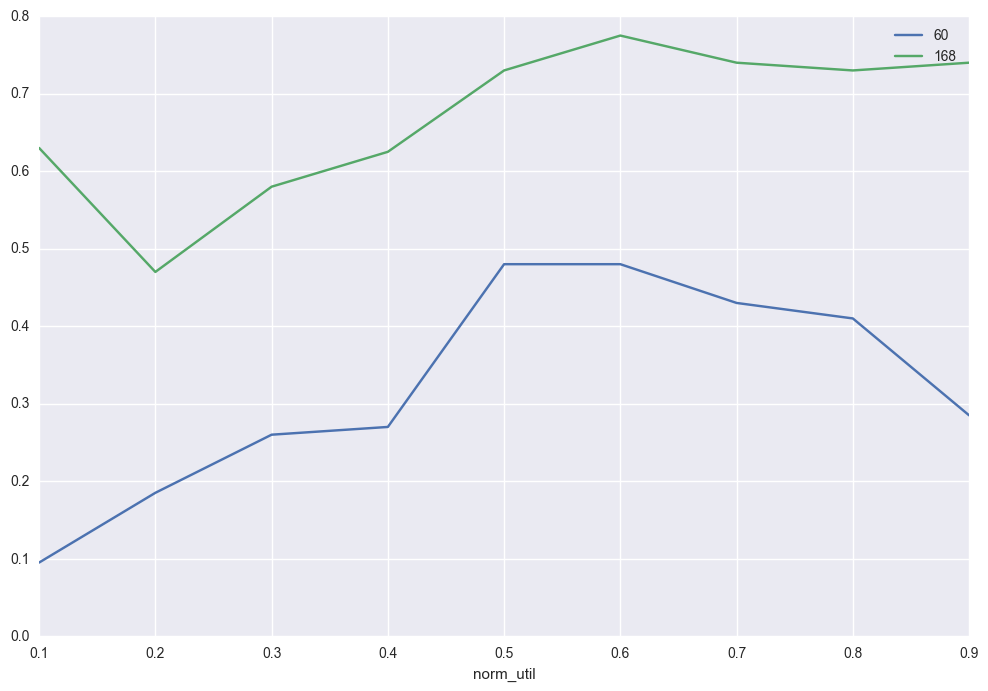

In [38]:
group = results.dropna().groupby(["period_in_hours", "norm_util"])["fragmentation"].median()
group.loc[60].plot(label=60)
group.loc[168].plot(label=168)
plt.legend()

## 5. Select experiments inputs with different fragmentation and utilisation level inside these workloads


We need a period of 60 hours (1 week-end) to fit with Grid'5000 limitation on experiment time. Also, we select a sample with an utilisation of 60%. This utilisation level is selected because it is considered to be representative for this cluster that as 60% mean utilisation and it is the worst case in term of fragmentation.

Study for 60 hours period and 60% utilisation:

Example for 60 hours period and 60% utilisation
Median=0.48 for the extract extracted_HPC2N-2002-2.2-cln_60H_60util+-0.1_4.


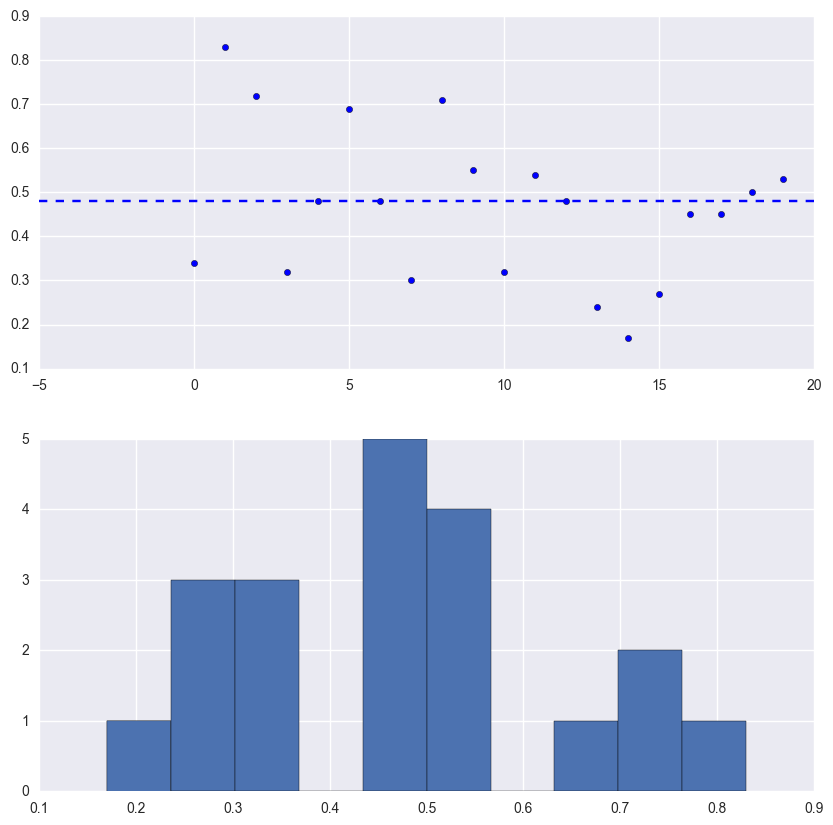

In [39]:
result_60h_60u = results[(results.period_in_hours == 60) & (results.norm_util == 0.6)].dropna()
median = result_60h_60u.median()["fragmentation"]
index = result_60h_60u[result_60h_70u.fragmentation == median].index[0]

# show median
print("Example for 60 hours period and 60% utilisation")
print("Median={} for the extract {}.".format(median, index))
# plot 
width = 10
height = 10
fig, axe = plt.subplots(nrows=2, figsize=(width, height))

axe[0].scatter(result_60h_60u.iteration, result_60h_60u.fragmentation)
axe[0].axhline(median, color='b', linestyle='--')
result_60h_60u.fragmentation.hist(ax=axe[1])

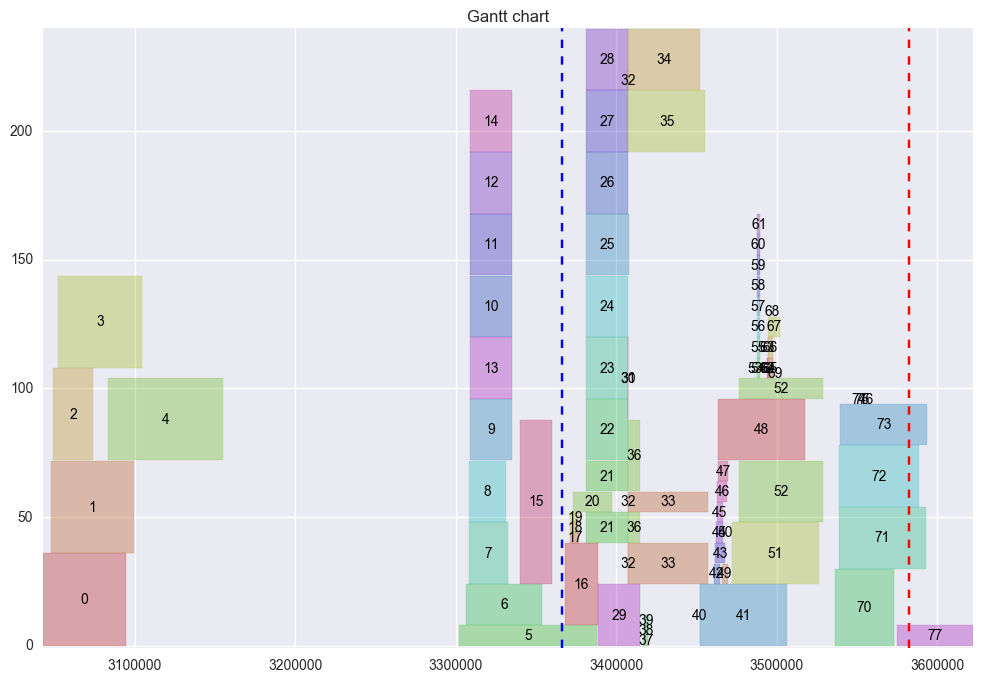

In [40]:
selected_trace = index
js = JobSet.from_csv("./fragmentation_results/{}_jobs.csv".format(selected_trace))
begin = extract_metadata.loc[selected_trace].begin
end = extract_metadata.loc[selected_trace].end
js.gantt()
plt.gca().axvline(begin, color='b', linestyle='--')
plt.gca().axvline(end, color='r', linestyle='--')

## 6. Generate simple HPC workload for experiment

We want to define simple use case that highlight bebida's behavior for nominal and limit cases. To do so, we will run benchmarks and interfere with simple HPC workload that has different utilisation and fragmentation level on the cluster.




## Possible futur optimization

- Improve BDAF kill tolerence
  - See if chronos (the scheduler from KerData inria team) can help or implement similar behavior
 
*Notes:* Spark seems to be pretty good for reschedule when executor
  are lost but it do not use newly available resources when a job is
  running, Hadoop is better at this because it allows
  
- Improve RJMS scheduling to avoid killing used resources
  - Experiments to show which scheduling algorithm fits the most (minimize waisted time) for the BDAF resource usage
  - Add a small coupeling by adding some information on what are resources currently in used by the BDAF to avoid killing them
  - Put workers in besteffort jobs:
    - Put a job per node on each available resources: Need a third tool to submit jobs
    - make the BDAF submit BE jobs when starting executors: Strong coupleling (to be avoided)
  - do not do epilogue / prologue if the next job will start directly after this one
